In [ ]:
!pip install --upgrade tfds-nightly
!pip install --upgrade tensorflow tensorflow-datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 96.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 100.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.5 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Succe

In [ ]:
import time
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# EMNIST 데이터셋 로드
ds_builder = tfds.builder("emnist/balanced")
ds_builder.download_and_prepare()
ds_info = ds_builder.info
dataset = ds_builder.as_data_source()

# Label Mapping
label_mapping = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
    'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
    'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't'
]

# 이미지 크기 조정 및 정규화
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # 이미지 크기를 224x224로 조정
    image = tf.image.grayscale_to_rgb(image)    # 그레이스케일 이미지를 RGB로 변환
    image = image / 255.0                       # 정규화
    label = tf.keras.utils.to_categorical(label, num_classes=47)  # 원-핫 인코딩
    return image, label

# 데이터 생성 (train, test)
X = []
y = []
for example in dataset['train']:
    X.append(example['image'])
    y.append(example['label'])

X_test = []
y_test = []
for example in dataset['test']:
    X_test.append(example['image'])
    y_test.append(example['label'])

X = np.array(X)
y = np.array(y)

X_test = np.array(X_test)
y_test = np.array(y_test)

# dataset 분할 (train:validation = 5:1), test dataset은 emnist dataset에 있는 것으로 사용
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=1/6, random_state=42)

# 데이터셋 구성 및 배치 설정
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(preprocess).shuffle(1000).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).map(preprocess).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(preprocess).batch(32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/112800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/incomplete.3WFHKJ_3.1.0/emnist-train.array_record*...:   0…

Generating test examples...:   0%|          | 0/18800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/incomplete.3WFHKJ_3.1.0/emnist-test.array_record*...:   0%…

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/balanced/3.1.0. Subsequent calls will reuse this data.


In [ ]:
from tensorflow.keras import layers, models

# SENet 블록 정의
def se_block(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Dense(filters // reduction, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)
    return layers.multiply([input_tensor, se])

# SENet 모델 정의
def create_senet_model(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = se_block(x)

    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = se_block(x)

    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = se_block(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# 모델 생성
input_shape = (224,224,3)
num_classes = 47
model = create_senet_model(input_shape, num_classes)
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 224, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 112, 64)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ max_pooling2d[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            260 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │            320 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 112, 112, 64)   │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 112, 112, 128)  │         73,856 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 56, 56, 128)    │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ max_pooling2d_1[0][0]  │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 8)              │          1,032 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │          1,152 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 128)      │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 56, 56, 128)    │              0 │ max_pooling2d_1[0][0], │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 256)    │        295,168 │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2      

 Total params: 459,915 (1.75 MB)

 Trainable params: 459,915 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 학습 시작 시간
start_time = time.time()

# 모델 학습
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset)

# 학습 시간 계산
training_time = time.time() - start_time


Epoch 1/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 354s 114ms/step - accuracy: 0.0505 - loss: 3.6307 - val_accuracy: 0.2040 - val_loss: 2.8243
Epoch 2/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 335s 103ms/step - accuracy: 0.1771 - loss: 2.8516 - val_accuracy: 0.2384 - val_loss: 2.5911
Epoch 3/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 322s 103ms/step - accuracy: 0.2113 - loss: 2.6925 - val_accuracy: 0.2682 - val_loss: 2.4712
Epoch 4/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 302s 103ms/step - accuracy: 0.2424 - loss: 2.5810 - val_accuracy: 0.3131 - val_loss: 2.3227
Epoch 5/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 324s 103ms/step - accuracy: 0.2715 - loss: 2.4846 - val_accuracy: 0.3257 - val_loss: 2.2801
Epoch 6/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 320s 103ms/step - accuracy: 0.3003 - loss: 2.3868 - val_accuracy: 0.3684 - val_loss: 2.1263
Epoch 7/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 306s 104ms/step - accuracy: 0.3356 - loss: 2.2595 - val_accuracy: 0.4303 - val_loss: 1.9179
Epoch 8/20
2938/2938 ━━━━━━━━━━━━━━━━━━━━ 319s 103ms/step - ac

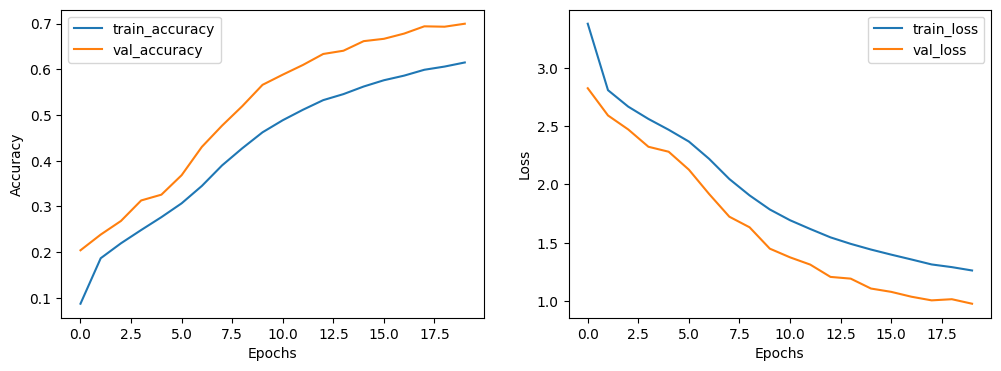

In [ ]:
# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# 모델 평가

start_time = time.time()  # 추론 시작 시간
test_loss, test_accuracy = model.evaluate(test_dataset)
end_time = time.time()  # 추론 종료 시간
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"훈련시간 : {training_time/60:.2f} minutes.")
print(f"평균 추론 시간: {average_inference_time:.4f} seconds.")

588/588 ━━━━━━━━━━━━━━━━━━━━ 48s 76ms/step - accuracy: 0.6955 - loss: 0.9987
Test Loss: 1.0016, Test Accuracy: 0.6959
훈련시간 : 105.62 minutes.
평균 추론 시간: 0.0046 seconds.
